In [48]:
import sys
sys.path.append('../')

In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from scripts.utils import set_mpl, data_path
from scripts.cross_match_scripts import cross_match_data_frames,  add_separation_columns
set_mpl()

%matplotlib inline
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy import coordinates

matplotlib settings set


In [50]:
def erosita_x_ray_filter(ero_df: pd.DataFrame,
                    DL_thresh: float = 6,
                    EL_thresh: float = 6,) -> pd.DataFrame:
    """
    erosita_x_ray_filter cleans erosita catalog from sources with small detection likelihood and extended sources, also removes duplicates from the

    Args:
        ero_df (pd.DataFrame): DataFrame of eROSITA data from Lockman Hole. Normally it would be `ERO_lhpv_03_23_sd01_a15_g14_orig.pkl` file
        DL_thresh (float, optional): minimum Detection likelihood . Defaults to 6.
        EL_thresh (float, optional): Maximum extension likelihood. Defaults to 6.
    
    Returns:
        pd.DataFrame: DataFrame with cleaned eROSITA data
    """  



    def cross_match_with_itself(xcat):
        xcat_matched = xcat.copy()
        c = SkyCoord(ra=xcat['RA_fin']*u.degree, dec=xcat['DEC_fin']*u.degree)
        catalog = SkyCoord(ra=xcat['RA_fin']*u.degree, dec=xcat['DEC_fin']*u.degree)
        idx, ero2ero, _ = c.match_to_catalog_sky(catalog, nthneighbor=2)
        ero2ero = ero2ero.to(u.arcsec).value

        xcat_matched['sep_to_closest'] = ero2ero
        xcat_matched.loc[:, 'srcname_fin_closest']  = xcat_matched.iloc[idx]['srcname_fin'].values
        xcat_matched = xcat_matched.merge(xcat.rename(columns={'srcname_fin':'srcname_fin_closest'}), on='srcname_fin_closest', how='left', suffixes=('', '_closest'))

        xcat_matched['is_confused'] = xcat_matched.eval('sep_to_closest<10') # close pairs for sep < 10. They are marked and the brightest one is kept

        xcat_matched['ML_FLUX_0_ratio'] = xcat_matched.ML_FLUX_0/xcat_matched.ML_FLUX_0_closest
        xcat_matched['ML_CTS_0_ratio']  = xcat_matched.ML_CTS_0/xcat_matched.ML_CTS_0_closest
        xcat_matched['DET_LIKE_0_ratio'] = xcat_matched.DET_LIKE_0/xcat_matched.DET_LIKE_0_closest
        xcat_matched['sep_ero2ero'] = xcat_matched['sep_to_closest']
        xcat_matched['pos_r98_first'] = xcat_matched['pos_r98']
        xcat_matched['pos_r98_second'] = xcat_matched['pos_r98_closest']
        xcat_matched['should_be_deleted'] = (xcat_matched['is_confused']) &  (xcat_matched['ML_FLUX_0_ratio']<1) #so that we delete the one with lower ML_FLUX_0


        xcat_matched = xcat_matched[['srcname_fin', 'srcname_fin_closest', 'is_confused', 'ML_FLUX_0_ratio', 'ML_CTS_0_ratio', 'DET_LIKE_0_ratio', 'sep_ero2ero', 'pos_r98_first', 'pos_r98_second', 'should_be_deleted']]

        return xcat_matched


    ero_df = ero_df.copy()
    ero_df.reset_index(inplace=True, drop=True)
    print(f'Original number of sources: {len(ero_df)}')
    ero_df = ero_df.query(f'DET_LIKE_0>{DL_thresh} and EXT_LIKE<{EL_thresh}')
    print(f'Number of sources after DL and EL cuts: {len(ero_df)}')

    ero_df.sort_values(by = 'ML_FLUX_0', ascending=False, inplace=True)
    ero_df.drop_duplicates(subset=['srcname_fin'], inplace=True) #drop duplicated srcname from the catalog, keeping the one with the highest ML_FLUX_0


    #cross match with itself to remove duplicates
    ero_df_cross_matched  = cross_match_with_itself(ero_df)
    id_to_retain = ero_df_cross_matched[ero_df_cross_matched.should_be_deleted==False]['srcname_fin']
    ero_df = ero_df[ero_df.srcname_fin.isin(id_to_retain)]

    print(f'Number of sources after DL and EL cuts + duplicates removal: {len(ero_df)}')
    ero_df.reset_index(drop=True, inplace=True) #drop index

    return ero_df


def csc_error_converter(df: pd.DataFrame,
                        r0_colname='err_ellipse_r0',
                        r1_colname='err_ellipse_r1') -> pd.DataFrame:
    """
    The function converts default radii `r0_colname`
    and `r1_colname` to the one-sigma error.

    Args:
        df (pd.DataFrame): DataFrame with `r0_colname` and
        `r1_colname` columns.
        
        r0_colname (str): major radius of the 95% confidence
        level position error ellipse.
        Defaults to 'err_ellipse_r0'.
        
        r1_colname (str): minor radius of the 95% confidence
        level position error ellipse.
        Defaults to 'err_ellipse_r1'.

    Returns:
        pd.DataFrame: one-sigma error in arcseconds.
    """

    # Conversion coefficient
    csc_sigma_coeff = np.sqrt(-(1 / (2 * np.log(1 - .95))))

    err_r1 = df[r0_colname]
    err_r2 = df[r1_colname]
    # Effective error
    csc_err_eff = np.sqrt(err_r1 ** 2 + err_r2 ** 2)

    csc_1sigma = csc_sigma_coeff * csc_err_eff

    return csc_1sigma



def tsource_r(sigma: float, t_thresh: float) -> float:
    """
    Calculates the radius of circle which contains the probability `t_thresh`
    NOT to find a counterpart for a source with localization error `sigma`.

    Args:
        sigma (float): localization error in arcsec.
        t_thresh (float): probability to NOT find a counterpart.

    Returns:
        float: radius of circle in arcsec.
    """
    
    rsearch = sigma * np.sqrt(-2 * np.log(t_thresh))
    
    return rsearch



def vot2pd_csc(csc_cat_path: str,
               colnames: list,
               save_coords: bool = False, 
               radec_fits_name: str = 'cscresults_name_radec') -> pd.DataFrame:
    """
    The function converts the votable file to pandas DataFrame.

    Optionally saves the separate file with the coordinates and names of
    the CSC sources to the FITS file.

    Args:
        csc_cat_path (str): the path to the votable file.
        colnames (list): column names of the votable file.
        save_coords (bool): if True, saves the separate file with the coordinates
        and names of the CSC sources to the FITS file.
        radec_fits_name (str): name of the FITS file with
        the coordinates and names of the CSC sources to be saved.

    Returns:
        pd.DataFrame: converted catalogue.
    """
    
    vot_table = Table.read(csc_cat_path, format='votable')
    
    df = vot_table.to_pandas()
    df.columns = colnames

    one_sigma_errors = csc_error_converter(df)

    df = df.assign(radec_err = one_sigma_errors)

    df['r_98'] = tsource_r(sigma=df['radec_err'], t_thresh=.02)

    if save_coords:

        df_init_coords = df[['name', 'ra', 'dec']]
        Table.from_pandas(df_init_coords).write(f'data/{radec_fits_name}.fits', format='fits')

    return df



def poserr2sigma_coeff(conf_level: float) -> float:
    """
    Calculates convertion coefficient to go from
    positional error to sigma given confidence level.

    For details see:
    https://www.notion.so/Theory-ca6e7795b40c43b4ba6d96bc59727efa#b4d9fc11ff8243a3834e9eeba08c2273
    """
    coeff = (-2 * np.log(1 - conf_level)) ** -0.5
    
    return coeff


def pos_r(sigma: float, conf_level: float) -> float:
    """
    Calculates the radius of circle which contains the probability `conf_level`
    of finding (opposite to tsource_r()) a counterpart for a source with
    localization error `sigma`.

    For details see:
    https://www.notion.so/Theory-ca6e7795b40c43b4ba6d96bc59727efa#0ba88df64d2d4d9583f93d63dbe1b927

    Args:
        sigma (float): localization error in arcsec.
        conf_level (float): probability of finding a counterpart.

    Returns:
        float: radius of circle in arcsec.
    """
    
    r_pos = sigma * np.sqrt(-2 * np.log(1 - conf_level))

    return r_pos




def only_reliable_xmm(df: pd.DataFrame) -> pd.DataFrame:
    """
    Filters out unreliable XMM sources.
    """
    reliable_df = df[
                    ((df['sc_sum_flag'] == 0) |
                    (df['sc_sum_flag'] == 1)) &
                    (df['sc_det_ml'] > 10) &
                    ~(df['sc_var_flag'] == True) &
                    (df['sc_extent'] == 0) &
                    (df['confused'] == False)
                    ]

    return reliable_df


# eROSITA

In [51]:
xcat_orig = pd.read_pickle(data_path+'ERO_lhpv_03_23_sd01_a15_g14_orig.pkl')

xcat_orig = erosita_x_ray_filter(xcat_orig)
xcat_orig.to_pickle(data_path+'ERO_lhpv_03_23_sd01_a15_g14.pkl')
xcat_orig

Original number of sources: 9500
Number of sources after DL and EL cuts: 9228
Number of sources after DL and EL cuts + duplicates removal: 9215


,srcname_fin,RA_fin,DEC_fin,GLON,GLAT,pos_r98,DET_LIKE_0,ML_FLUX_0,ML_FLUX_ERR_0,ML_CTS_0,ML_CTS_ERR_0,ML_EXP_1,EXT,EXT_LIKE,EXT_ERR,ID_SRC,ID_CLUSTER,RA,DEC,RADEC_ERR,DIST_NN,SRCDENS,TSTART,TSTOP,EXT_LOWERR,EXT_UPERR,ML_RATE_0,ML_RATE_ERR_0,ML_BKG_0,RA_corr,DEC_corr,g_id,g_d2d,g_nsrc,g_s,g_gmag,g_maxLx,g_b,s_id,s_z,s_otype,s_d2d,s_nsrc,flag_xray,flag_radio,flag_agn_wise,w1,w2,w3,w1snr,w2snr,w3snr,w_nsrc,sdss_nsrc,sdss_p,sdss_id,sdss_sp,sdss_d2d,hpidx,RADEC_ERR_fin,pos_sigma_2d,pos_r68,pos_r95,ELON,ELAT,flux_05-20,NH
0,SRGe J103744.3+571156,159.434594,57.198788,151.771105,51.782607,2.041112,26414.902344,3.284168e-12,3.904461e-13,15460.503906,1838.058594,4300.765625,0.0,0.0,0.0,1,1,159.436603,57.197499,0.318530,6.785297,0.000011,6.268413e+08,6.270701e+08,0.0,0.0,3.594826,0.427379,20.898417,159.434594,57.198788,853989860956388736,6.040749,1,0,15.749939,-1.0,0,87GB 103431.3+572750,0.830700,BLLac,6.040664,4,1,1,1,12.218000,11.328000,9.144,46.2,51.7,34.4,1,3,1,1237658303278743603,7980433077213351936,6.099201,65741514189,0.318530,0.729711,1.101567,1.786149,134.901685,44.066998,2.527295e-12,5.451755e+19
1,SRGe J110137.5+572926,165.406353,57.490464,147.861359,53.996717,2.144203,5344.646973,1.969860e-12,5.570020e-14,1436.945923,40.631405,666.426941,0.0,0.0,0.0,21,14,165.408362,57.489175,0.433455,41.040825,0.000030,6.268413e+08,6.270701e+08,0.0,0.0,2.156194,0.060969,4.025409,165.406353,57.490464,857143329024245888,7.121849,2,1,10.012074,NaN,0,HD 237963,NaN,Star,7.105646,1,1,0,0,8.146000,8.155000,8.124,47.2,55.3,51.5,1,3,1,1237658302206378052,0,3.844748,64609311305,0.433455,0.766567,1.157204,1.876362,138.528408,46.042071,1.515884e-12,7.056474e+19
2,SRGe J110537.6+585120,166.406669,58.855424,145.639441,53.356921,2.076665,9683.065430,1.505411e-12,9.148949e-14,3063.068848,186.154160,1858.869995,0.0,0.0,0.0,7,4,166.408677,58.854134,0.361642,46.541451,0.000013,6.268413e+08,6.270701e+08,0.0,0.0,1.647812,0.100144,8.487207,166.406669,58.855424,860383349272777344,6.884830,3,0,16.935423,-1.0,0,2MASS J11053761+5851208,0.191000,Seyfert_1,6.883267,1,1,0,1,11.276000,10.261000,7.624,46.9,54.1,57.8,1,3,0,1237655108373839879,7996392488641515520,6.898202,59429013246,0.361642,0.742422,1.120754,1.817260,138.042449,47.467010,1.158473e-12,6.881141e+19
3,SRGe J102349.9+563347,155.958041,56.563186,154.343916,50.594493,2.027046,32979.832031,1.001123e-12,4.287407e-14,7451.697754,319.126190,6800.098145,0.0,0.0,0.0,3,2,155.960049,56.561896,0.161150,96.801712,0.000004,6.268413e+08,6.270701e+08,0.0,0.0,1.095822,0.046930,29.139788,155.958041,56.563186,853150108949817088,6.997905,1,0,17.967112,-1.0,0,2MASX J10234977+5633475,0.230353,Seyfert_1,6.999458,1,1,0,1,12.966000,12.035000,9.582,44.0,48.8,32.1,1,1,0,1237655108371152952,9216701424834203648,6.968698,68241429703,0.300000,0.724683,1.093975,1.773840,133.091566,42.558086,7.704034e-13,7.963453e+19
4,SRGe J105057.2+593215,162.738144,59.537414,147.091312,51.565006,2.041233,7492.464844,9.137326e-13,2.094327e-14,4687.587402,107.442131,4686.813965,0.0,0.0,0.0,4,3,162.740153,59.536125,0.226167,3.579206,0.000006,6.268413e+08,6.270701e+08,0.0,0.0,1.000165,0.022924,23.773006,162.738144,59.537414,861390055247564800,5.119823,2,1,18.398899,-1.0,0,2MASX J10505729+5932144,0.085280,Seyfert_1,5.102316,2,1,1,0,12.489000,11.947000,8.799,48.3,51.5,42.9,2,2,0,1237655368746336397,631642530626168832,5.075234,56915973694,0.318686,0.729755,1.101632,1.786255,135.192778,46.969604,7.031529e-13,7.898503e+19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9210,SRGe J102315.1+561957,155.813071,56.332561,154.718419,50.650679,12.277468,6.259035,1.637604e-15,6.023096e-16,14.734348,5.419283,8219.958008,0.0,0.0,0.0,8816,7662,155.815079,56.331271,3.503645,66.729698,0.000003,6.268413e+08,6.270701e+08,0.0,0.0,0.001793,0.000659,31.568741,

In [52]:
lh_ra_min = 154.763934
lh_ra_max = 167.084550
lh_dec_min = 54.124219
lh_dec_max = 61.236185

# Chandra Source Catalog (CSC)

In [53]:
# CSC table conversion
csc_columns = ['name', 'ra', 'dec', 'err_ellipse_r0', 'err_ellipse_r1', 'err_ellipse_ang',
               'significance', 'likelihood', 'likelihood_class', 'conf_flag', 'dither_warning_flag',
               'extent_flag', 'pileup_flag', 'sat_src_flag', 'streak_src_flag', 'var_flag',
               'flux_aper_s', 'flux_aper_lolim_s', 'flux_aper_hilim_s', 'flux_aper_m',
               'flux_aper_lolim_m', 'flux_aper_hilim_m']

# Filtration
# data/cscresults.vot obtained via CSCview software
csc_all = vot2pd_csc(csc_cat_path=data_path+'cscresults.vot', colnames=csc_columns)


csc_all = csc_all.query('ra > @lh_ra_min & ra < @lh_ra_max & dec > @lh_dec_min & dec < @lh_dec_max')

csc_all = csc_all.assign(flux_05_2 = lambda x: x.flux_aper_s + x.flux_aper_m)

# Ошибки на поток 0.5-2 кэВ
s_up = csc_all.flux_aper_hilim_s - csc_all.flux_aper_s
s_down = csc_all.flux_aper_s - csc_all.flux_aper_lolim_s
s_err = np.sqrt(s_up ** 2 + s_down ** 2)
m_up = csc_all.flux_aper_hilim_m - csc_all.flux_aper_m
m_down = csc_all.flux_aper_m - csc_all.flux_aper_lolim_m
m_err = np.sqrt(m_up ** 2 + m_down ** 2)
sm_err = np.sqrt(s_err ** 2 + m_err ** 2).values
csc_all['flux_05_2_err'] = sm_err


csc_all.to_pickle(data_path+'csc_all_lh.pkl')
print(f'CSC Sources (all): {csc_all.shape[0]}')


# CSC catalogue filtering
csc_df = csc_all[(csc_all['conf_flag'] == False) &
                              (csc_all['extent_flag'] == False) &
                              (csc_all['sat_src_flag'] == False) &
                              (csc_all['streak_src_flag'] == False) &
                              (csc_all['pileup_flag'] == False) &
                              (csc_all['dither_warning_flag'] == False)]


csc_df = csc_df[(csc_df['likelihood'] > 10) &
                                  (csc_df['likelihood'] < 10 ** 10)]


csc_df.to_pickle(data_path+'csc_cleared_lh.pkl')

print(f'CSC Sources (filtered): {csc_df.shape[0]}')
csc_df.sample(5)


CSC Sources (all): 2329
CSC Sources (filtered): 2029


,name,ra,dec,err_ellipse_r0,err_ellipse_r1,err_ellipse_ang,significance,likelihood,likelihood_class,conf_flag,dither_warning_flag,extent_flag,pileup_flag,sat_src_flag,streak_src_flag,var_flag,flux_aper_s,flux_aper_lolim_s,flux_aper_hilim_s,flux_aper_m,flux_aper_lolim_m,flux_aper_hilim_m,radec_err,r_98,flux_05_2,flux_05_2_err
126824,2CXO J105325.3+544803,163.355702,54.801096,1.321757,0.955515,48.979598,1.945946,15.983167,TRUE,False,False,False,False,False,False,False,5.416930e-16,1.128527e-16,9.705333e-16,NaN,NaN,NaN,0.666313,1.863778,NaN,NaN
117787,2CXO J104323.4+585248,160.847881,58.880230,2.090691,1.368129,7.606672,2.611111,21.202218,TRUE,False,False,False,False,False,False,False,4.478598e-16,1.081041e-16,7.721721e-16,2.814800e-16,7.578307e-17,4.871769e-16,1.020756,2.855208,7.293398e-16,5.524806e-16
114361,2CXO J103208.3+574123,158.034857,57.689769,2.007341,2.007336,0.000000,1.777778,11.458316,MARGINAL,False,False,False,False,False,False,False,0.000000e+00,0.000000e+00,2.464349e-16,NaN,NaN,NaN,1.159763,3.244030,NaN,NaN
114522,2CXO J103253.1+575357,158.221255,57.899274,1.166409,0.888421,96.741510,2.864865,28.305781,TRUE,False,False,False,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,0.599008,1.675516,NaN,NaN
120469,2CXO J104437.5+585306,161.156307,58.885211,0.949425,0.782963,146.843703,6.119756,135.187686,TRUE,False,False,False,False,False,False,False,3.197977e-16,8.291051e-17,5.448405e-16,1.140686e-15,7.804695e-16,1.480891e-15,0.502759,1.406291,1.460484e-15,5.935108e-16


# 4XMM DR10

In [56]:
xmm_all = pd.read_csv(data_path+'4XMM_DR10cat_slim_v1.0.csv')
xmm_all.replace('t', True, inplace=True)
xmm_all.replace('f', False, inplace=True)

xmm_all = xmm_all.query('sc_ra > @lh_ra_min & sc_ra < @lh_ra_max & sc_dec > @lh_dec_min & sc_dec < @lh_dec_max')

# Поток 0.5-2 кэВ
xmm_all = xmm_all.assign(flux_05_2 = lambda x: x.sc_ep_2_flux + x.sc_ep_3_flux)
# Ошибки на поток 0.5-2 кэВ
xmm_all = xmm_all.assign(flux_05_2_err = lambda x: np.sqrt(x.sc_ep_2_flux_err ** 2 + x.sc_ep_3_flux_err ** 2))

xmm_err = xmm_all['sc_poserr']
xmm_sigma_coeff = poserr2sigma_coeff(.63)
xmm_sigma = xmm_sigma_coeff * xmm_err
xmm_all['sigma'] =  xmm_sigma
# pos_r98
xmm_r98 = pos_r(xmm_sigma, .98)
xmm_all['r_98'] =  xmm_r98

xmm_all.to_pickle(data_path+'xmm_all_lh.pkl')
print(f'XMM Sources (all): {xmm_all.shape[0]}')

xmm_df = only_reliable_xmm(xmm_all) 
xmm_df.to_pickle(data_path+'xmm_cleared_lh.pkl')
print(f'XMM Sources (filtered): {xmm_df.shape[0]}')
xmm_df.sample(5)

XMM Sources (all): 1791
XMM Sources (filtered): 1316


,srcid,iauname,sc_ra,sc_dec,sc_poserr,sc_det_ml,sc_ep_1_flux,sc_ep_1_flux_err,sc_ep_2_flux,sc_ep_2_flux_err,sc_ep_3_flux,sc_ep_3_flux_err,sc_ep_4_flux,sc_ep_4_flux_err,sc_ep_5_flux,sc_ep_5_flux_err,sc_ep_8_flux,sc_ep_8_flux_err,sc_ep_9_flux,sc_ep_9_flux_err,sc_ep_8_fmin,sc_ep_8_fmin_err,sc_ep_8_fmax,sc_ep_8_fmax_err,sc_hr1,sc_hr1_err,sc_hr2,sc_hr2_err,sc_hr3,sc_hr3_err,sc_hr4,sc_hr4_err,sc_extent,sc_ext_err,sc_ext_ml,sc_chi2prob,sc_var_flag,sc_sum_flag,mjd_first,mjd_last,sc_fvar,sc_fvarerr,n_detections,confused,webpage_url,flux_05_2,flux_05_2_err,sigma,r_98
252621,205541201010073,4XMM J104718.8+585957,161.828611,58.999277,0.801812,79.3873,4.661150e-15,7.596710e-16,3.629150e-15,6.722580e-16,3.647240e-15,6.944940e-16,2.931860e-15,1.372010e-15,1.227860e-14,9.364610e-15,3.163260e-14,9.733120e-15,1.400450e-14,1.670200e-15,2.718280e-14,1.138530e-14,6.362680e-14,5.178500e-14,-0.063926,0.109112,0.017542,0.107558,-0.512715,0.147462,0.450215,0.248275,0.0,NaN,-0.706301,0.947094,False,1,54750.880949,54932.883727,NaN,NaN,4,False,http://xmm-catalog.irap.omp.eu/source/20554120...,7.276390e-15,9.665675e-16,0.568603,1.590468
254086,205562114010053,4XMM J105034.9+591632,162.645805,59.275728,1.679140,20.1425,5.130530e-16,4.769910e-16,1.167580e-15,6.277040e-16,2.631140e-15,1.026440e-15,8.659240e-15,2.934140e-15,1.253130e-14,1.260880e-14,2.998880e-14,1.336260e-14,9.988030e-15,2.235510e-15,2.998880e-14,1.336260e-14,2.998880e-14,1.336260e-14,0.285475,0.362014,0.367057,0.256598,-0.057372,0.232309,-0.317579,0.303470,0.0,NaN,-0.780600,NaN,NaN,0,54790.964190,54791.066424,NaN,NaN,1,False,http://xmm-catalog.irap.omp.eu/source/20556211...,3.798720e-15,1.203159e-15,1.190758,3.330729
252333,205562116010034,4XMM J104620.0+572926,161.583437,57.490714,1.413920,20.3040,2.889270e-15,9.097770e-16,1.950230e-15,8.329890e-16,8.588690e-16,7.801120e-16,8.771880e-16,1.468420e-15,1.762450e-14,1.504680e-14,3.159720e-14,1.578270e-14,7.036490e-15,2.294940e-15,3.159720e-14,1.578270e-14,3.159720e-14,1.578270e-14,-0.333076,0.223049,-0.064730,0.322147,-0.474878,0.258419,0.547687,0.315903,0.0,NaN,-0.783129,NaN,NaN,0,54799.044537,54799.125949,NaN,NaN,1,False,http://xmm-catalog.irap.omp.eu/source/20556211...,2.809099e-15,1.141247e-15,1.002678,2.804641
246998,203032602010017,4XMM J103522.8+574116,158.845236,57.687942,0.633118,504.2580,1.210590e-14,1.022500e-15,1.052050e-14,9.647400e-16,1.044980e-14,1.094510e-15,1.767740e-14,2.710980e-15,3.184860e-14,1.565280e-14,8.409360e-14,1.618900e-14,4.077490e-14,2.572790e-15,8.405780e-14,2.432000e-14,8.412210e-14,2.169380e-14,-0.066573,0.060604,-0.092361,0.067672,-0.251393,0.085679,-0.103535,0.176561,0.0,NaN,-1.700480,0.186595,False,0,53467.914178,53510.606285,0.172432,0.132196,2,False,http://xmm-catalog.irap.omp.eu/source/20303260...,2.097030e-14,1.458998e-15,0.448974,1.255848
246826,203032605010053,4XMM J103453.5+574633,158.723205,57.776099,1.607870,32.1578,9.707300e-16,4.305640e-16,1.065960e-15,5.541840e-16,1.015080e-15,6.258640e-16,3.498860e-16,1.133020e-15,7.550110e-15,8.706910e-15,1.269910e-14,8.905740e-15,2.428950e-15,1.188210e-15,1.269910e-14,8.905740e-15,1.269910e-14,8.905740e-15,-0.260392,0.194768,0.447874,0.222935,-0.891795,0.204820,0.869833,0.237381,0.0,NaN,-0.935555,NaN,NaN,0,53510.296782,53510.606285,NaN,NaN,1,False,http://xmm-catalog.irap.omp.eu/source/20303260...,2.081040e-15,8.359579e-16,1.140217,3.189358


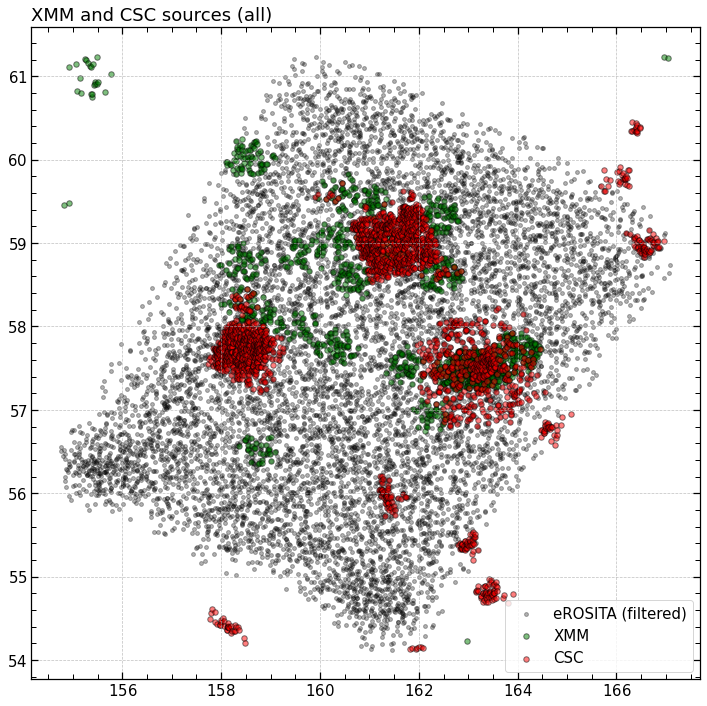

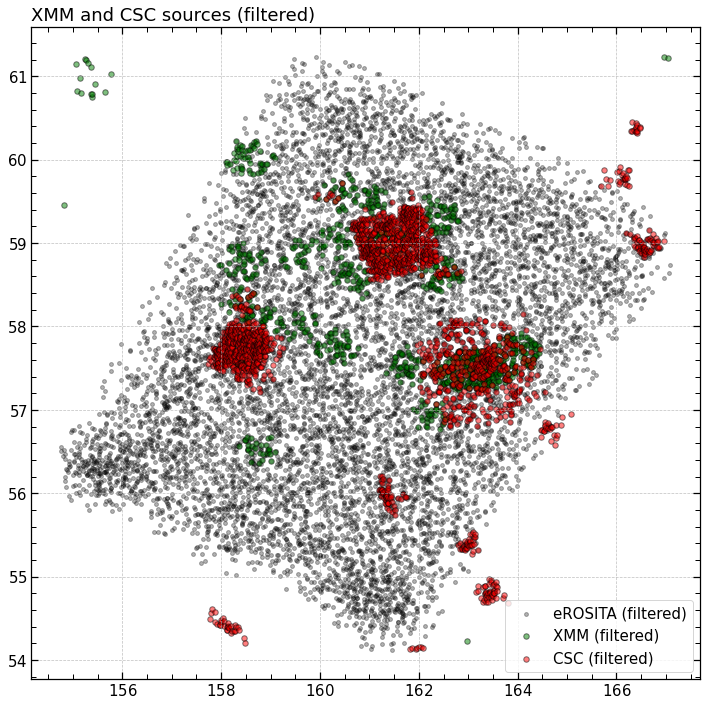

In [65]:
fig,  ax =  plt.subplots( figsize = (12,12))

ax.scatter(xcat_orig.RA_fin, xcat_orig.DEC_fin, s=15, c='k', label='eROSITA (filtered)', alpha = 0.3)
ax.scatter(xmm_all.sc_ra, xmm_all.sc_dec, s=30, c='g', label='XMM', alpha = 0.5)
ax.scatter(csc_all.ra, csc_all.dec, s=30, c='r', label='CSC', alpha =0.5)
plt.title('XMM and CSC sources (all)')
plt.legend()


fig,  ax =  plt.subplots( figsize = (12,12))

ax.scatter(xcat_orig.RA_fin, xcat_orig.DEC_fin, s=15, c='k', label='eROSITA (filtered)', alpha = 0.3)
ax.scatter(xmm_df.sc_ra, xmm_df.sc_dec, s=30, c='g', label='XMM (filtered)', alpha = 0.5)
ax.scatter(csc_df.ra, csc_df.dec, s=30, c='r', label='CSC (filtered)', alpha =0.5)
plt.title('XMM and CSC sources (filtered)')
plt.legend()